In [1]:
import os
import sys
import time
import json
import datetime
import random
import tarfile

import numpy as np
import pandas as pd
from PIL import Image

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
get_available_gpus()

['/device:GPU:0']

In [4]:
PATH = "../tubs/tub5" #Shadow

In [7]:
json_files = [file for file in os.listdir(PATH) if file.endswith('json') ]

In [8]:
len(json_files)

38575

In [35]:
meta_json = pd.read_json(f'{PATH}/{json_files[0]}')

In [36]:
meta_json

,inputs,types
0,cam/image_array,image_array
1,user/angle,float
2,user/throttle,float
3,user/mode,str
4,timestamp,str


In [28]:
with open(f'{PATH}/{json_files[1]}', 'r') as f:
    data = json.load(f)

In [30]:
data["user/throttle"]

1.08

In [41]:
df = pd.DataFrame(data, index = [0])

In [42]:
df

,cam/image_array,user/throttle,user/angle,timestamp,user/mode
0,0_cam-image_array_.jpg,0.08,0.01,None,user


In [43]:
df["cam/image_array"][0]

'0_cam-image_array_.jpg'

In [9]:
def json_to_df(PATH, json_files, max_items=None):
    df = pd.DataFrame()
    for i, j in enumerate(json_files[1:max_items]):
        with open(f'{PATH}/{j}') as f:
            data = json.load(f)

            userThrottle = data["user/throttle"]
            userAngle = data["user/angle"]
            camImage_array = data["cam/image_array"]
            index = int(camImage_array[:-21])
            df_row = pd.DataFrame([[userThrottle, userAngle, camImage_array]], index = [index], columns = ["user/throttle", "user/angle", "cam/image_array"])

            df = df.append(df_row)
    df = df.sort_index()
    return df

In [95]:
len(json_files[1:None])

38574

In [10]:
df = json_to_df(PATH, json_files, max_items=None)

In [5]:
df = pd.read_feather('tmp/df')

C:\Users\Jason\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [6]:
df.head()

,user/throttle,user/angle,cam/image_array
0,0.08,0.01,0_cam-image_array_.jpg
1,0.12,-0.03,1_cam-image_array_.jpg
2,0.12,-0.03,2_cam-image_array_.jpg
3,0.14,-0.06,3_cam-image_array_.jpg
4,0.14,-0.06,4_cam-image_array_.jpg


In [7]:
def to_bin(a):
    arr = np.zeros(15)
    a = a + 1
    b = round(a/(2/14))
    arr[int(b)] = 1
    return arr

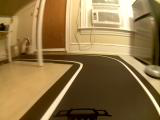

In [8]:
img_name = df['cam/image_array'][100]
img = Image.open(f'{PATH}/{img_name}')
img

In [9]:
val = np.array(img)

In [10]:
val.shape

(120, 160, 3)

In [11]:
bs = 128
train_frac = 0.8
X_keys = ['cam/image_array']
y_keys = ['user/angle', 'user/throttle']
PATH
new_model_path = 'models/pilot_jn'

In [12]:
def read_record(record_dict, path = PATH):
    data = {}
    for key, val in record_dict.items():
        if key == 'cam/image_array':
            img = Image.open(f'{PATH}/{val}')
            val = np.array(img)
        
        data[key] = val
    return data

In [13]:
# df_t = df.sample(n=1).to_dict(orient='record')[0]

In [14]:
# record = read_record(df_t)

In [15]:
# record['cam/image_array'][None].shape

In [16]:
def get_record_gen(record_transform=None, shuffle=True, df=None):
    while True:
        for _ in df.iterrows():
            if shuffle:
                record_dict = df.sample(n=1).to_dict(orient='record')[0]
            
            record_dict = read_record(record_dict)
            
            if record_transform:
                record_dict = record_transform(record_dict)
            
            yield record_dict

In [17]:
# record_gen = get_record_gen(record_transform=None, shuffle=True, df=df)

In [18]:
# next(record_gen)

In [19]:
def get_batch_gen(keys=None, batch_size=128, record_transform=None, shuffle=True, df=None):
    
    record_gen = get_record_gen(record_transform=record_transform, shuffle=shuffle, df=df)
    
    while True:
        record_list = [next(record_gen) for _ in range(batch_size)]
        
        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            batch_arrays[k] = arr
        yield batch_arrays

In [20]:
def get_train_gen(X_keys, Y_keys, batch_size=128, record_transform=None, df=None): #
    batch_gen = get_batch_gen(X_keys + Y_keys, batch_size=batch_size,
                                  record_transform=record_transform, df=df)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys] 
        yield X, Y

In [21]:
def get_train_val_gen(df, X_keys, Y_keys, batch_size = 128, train_frac=0.8, #
                      train_record_transform=None, val_record_transform=None): #
    train_df = df.sample(frac=train_frac, random_state=200) #
    val_df = df.drop(train_df.index) #
    
    train_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                             record_transform=train_record_transform, df=train_df)
    val_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                           record_transform=val_record_transform, df=val_df)
    return train_gen, val_gen
    

In [22]:
def record_transform(record):
    record['user/angle'] = to_bin(record['user/angle'])
    return record

In [23]:
train_gen, val_gen = get_train_val_gen(df, X_keys, y_keys,
                                               train_record_transform=record_transform, #
                                               val_record_transform=record_transform, #
                                               batch_size=bs, #
                                               train_frac=train_frac) #

In [24]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Convolution2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Cropping2D, Lambda
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
def default_categorical():
    img_in = Input(shape=(120, 160, 3),
                   name='img_in')  # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5, 5), strides=(2, 2), activation='relu')(
        x)  # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5, 5), strides=(2, 2), activation='relu')(
        x)  # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5, 5), strides=(2, 2), activation='relu')(
        x)  # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3, 3), strides=(2, 2), activation='relu')(
        x)  # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3, 3), strides=(1, 1), activation='relu')(
        x)  # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)  # Flatten to 1D (Fully connected)
    x = Dense(100, activation='relu')(x)  # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)  # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='relu')(x)  # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)  # Randomly drop out 10% of the neurons (Prevent overfitting)
    # categorical output of the angle
    angle_out = Dense(15, activation='softmax', name='angle_out')(
        x)  # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0

    # continous output of throttle
    throttle_out = Dense(1, activation='relu', name='throttle_out')(x)  # Reduce to 1 number, Positive number only

    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'categorical_crossentropy',
                        'throttle_out': 'mean_absolute_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .01})

    return model

In [26]:
model = default_categorical()

In [27]:
def train(train_gen, val_gen, saved_model_path, epochs=100, steps=100, train_split=0.8,
         verbose=1, min_delta=0.0005, patience=5, use_early_stop=True):
    
#     checkpoint to save model
    save_best = ModelCheckpoint(saved_model_path, monitor='val_loss', verbose=verbose, save_best_only=True, mode='min')
    
    #stop training if stop improving
    early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=verbose, mode='auto')
    
    callbacks_list = [save_best]
    
    if use_early_stop:
        callbacks_list.append(early_stop)
        
    hist = model.fit_generator(train_gen, steps_per_epoch=steps, epochs=epochs, verbose=1, validation_data=val_gen,
                                callbacks=callbacks_list, validation_steps=steps * (1.0 - train_frac)//train_frac)
    return hist

In [28]:
total_records = len(df)
total_train = int(total_records * train_frac)
total_val = total_records - total_train
steps_per_epoch = total_train // bs
steps_per_epoch

241

In [ ]:
train(train_gen, val_gen, saved_model_path=new_model_path, steps=steps_per_epoch, train_split=0.8)

Epoch 1/100


In [175]:
#check against original
def unbin(arr):
    index = np.argmax(arr)
    return index/14*2-1
#     return index

In [174]:
unbin([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

0.0

In [176]:
def run(img_arr):
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    angle_binned, throttle = model.predict(img_arr)
    angle_unbinned = unbin(angle_binned[0])
    return angle_unbinned, throttle[0][0]

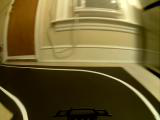

In [194]:
img_name = df['cam/image_array'][150]
img = Image.open(f'{PATH}/{img_name}')
img

In [195]:
val = np.array(img)

In [196]:
val.shape

(120, 160, 3)

In [198]:
#prediction
run(val)

(-0.4285714285714286, 0.31011686)

In [199]:
#compare to actual data
df['user/angle'][150], df['user/throttle'][150]

(-0.42, 0.27)